In [168]:
#Import Libraries
from bs4 import BeautifulSoup
import re
import pandas as pd
from spellchecker import SpellChecker
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import matplotlib
from textblob import TextBlob

import numpy as np
# Install new libraries
#%pip install pyspellchecker
#%pip install TextBlob

In [169]:
preprocessed_vodafone_reviews = pd.read_csv('pre_processed_vodafone_data.csv')  

In [170]:
# Fix representation of lists in the imported csv :(

# Abstract syntax tree is used to recreate the lists of tuples stored in the pre-processed data
import ast

for i in range(len(preprocessed_vodafone_reviews)):
    preprocessed_vodafone_reviews.sentences.iloc[i] = list(ast.literal_eval(preprocessed_vodafone_reviews.sentences.iloc[i]))
    preprocessed_vodafone_reviews.noun_phrases.iloc[i] = list(ast.literal_eval(preprocessed_vodafone_reviews.noun_phrases.iloc[i]))
    preprocessed_vodafone_reviews.lemmatised_sentences.iloc[i] = list(ast.literal_eval(preprocessed_vodafone_reviews.lemmatised_sentences.iloc[i]))
    preprocessed_vodafone_reviews.bi_grams.iloc[i] = list(ast.literal_eval(preprocessed_vodafone_reviews.bi_grams.iloc[i]))
    preprocessed_vodafone_reviews.tri_grams.iloc[i] = list(ast.literal_eval(preprocessed_vodafone_reviews.tri_grams.iloc[i]))
    
preprocessed_vodafone_reviews

,review_id,title,review,score,review_sentiment,sentences,lemmatised_title,noun_phrases,lemmatised_sentences,bi_grams,tri_grams
0,1,vodaphone almost ruined my life - stolen ident...,my email and password were part of a company d...,1,-0.9390,[(vodaphone almost ruined my life - stolen ide...,vodaphone almost ruin life steal identity secu...,"[(company database leak, -0.34, 1), (vodafone ...",[(vodaphone almost ruin life steal identity se...,"[(ruin life, -0.5584, 1), (life steal, -0.5584...","[(vodaphone almost ruin, -0.5584, 1), (ruin li..."
1,2,misguided sale,"misguided salecouple of days ago, i was told t...",1,0.8555,"[(misguided sale, 0.0, 1), (misguided salecoup...",misguide sale,"[(trade in value, 0.34, 1), (old phone, 0.34, ...","[(misguide, 0.0, 1), (misguided salecouple day...","[(misguide sale, 0.0, 1), (misguided salecoupl...","[(misguided salecouple day, 0.34, 1), (trade i..."
2,3,worst network,worst network for data in australia. i used vo...,1,-0.6858,"[(worst network, -0.6249, 1), (worst network f...",bad network,"[(mobile phone, -0.7227, 1), (i need data, -0....","[(bad network, -0.6249, 1), (bad network data ...","[(bad network, -0.6249, 1), (bad network, -0.6...","[(network for data, -0.6249, 1), (i use vodafo..."
3,4,insurance contract with them is bulshit,they charged me for over a year a plan with in...,1,0.3612,"[(insurance contract with them is bulshit, 0.0...",insurance contract with them bulshit,"[(insurance contract, 0.0, 1), (free phone, 0....","[(insurance contract bulshit, 0.0, 1), (charge...","[(insurance contract, 0.0, 1), (year plan, 0.3...","[(plan with insurance, 0.3612, 1), (month free..."
4,5,record all your phonecalls with them when you ...,my parents and i have been with vodafone for a...,1,0.4926,[(record all your phonecalls with them when yo...,record all your phonecalls with them when you ...,"[(decent coverage, 0.0, 1), (cheap price, 0.0,...","[(record phonecalls issue, 0.0, 1), (parent vo...","[(decent coverage, 0.0, 1), (cheap price, 0.0,...","[(thats strictly due, 0.0, 1), (company with d..."
...,...,...,...,...,...,...,...,...,...,...,...
1898,11,below average,"vodafone extremely cheap, now i know why. terr...",2,0.1450,"[(below average, 0.0, 2), (vodafone extremely ...",below average,"[(terriblee network reliability, -0.6249, 2), ...","[(average, 0.0, 2), (vodafone extremely cheap ...","[(terriblee network, -0.6249, 2), (network rel...","[(vodafone extremely cheap, 0.0, 2), (terrible..."
1899,12,poor customer service and tend to charge more ...,i reduced my plan to$22 from $35 thinking it w...,1,-0.9658,[(poor customer service and tend to charge mor...,poor customer service and tend charge more and...,"[(poor customer service, -0.4767, 1), (mobile ...",[(poor customer service tend charge see possib...,"[(poor customer, -0.4767, 1), (customer servic...","[(poor customer service, -0.4767, 1), (i reduc..."
1900,13,insensitive to the customer sufferings,please never ever make mistake of going with v...,1,-0.1935,"[(insensitive to the customer sufferings, -0.2...",insensitive the customer suffering,"[(customer suffering, -0.2263, 1), (whole busi...","[(insensitive customer suffering, -0.2263, 1),...","[(customer suffering, -0.2263, 1), (whole busi...","[(mistake with vodafone, 0.5165, 1), (i spoil ..."
1901,14,extremely terrible customer service at westfie...,i had to get my address changed (same as on my...,1,-0.9247,[(extremely terrible customer service at westf...,extremely terrible customer service westfield ...,"[(terrible customer service, -0.5256, 1), (wes...",[(extremely terrible customer service westfiel...,"[(terrible customer, -0.5256, 1), (customer se...","[(terrible customer service, -0.5256, 1), (ser..."


<AxesSubplot:>

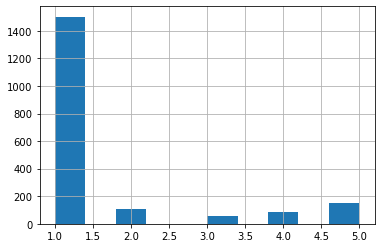

In [171]:
##########################################
##  Some EDA

preprocessed_vodafone_reviews['score'] = pd.to_numeric(preprocessed_vodafone_reviews['score'])

preprocessed_vodafone_reviews['score'].hist()


<AxesSubplot:>

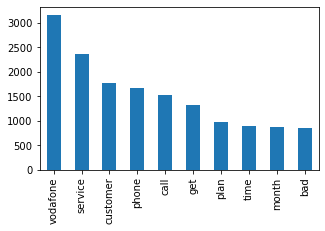

In [172]:
def strip_punct(word):
    word =  re.sub("[,\.;:\(\)\{\}\[\]!?\"\s\n]+", " ", word)
    word =  re.sub("\s+", " ", word)
    return word

def list_of_words(df, column):
    word_frame = pd.DataFrame(columns = ["words"])
    for i in range(len(df)):
        for sentence in df[column].iloc[i]:
            words = sentence[0].split(" ")
            word_frame = word_frame.append(pd.DataFrame(words,columns = ["words"]))
        
    return word_frame




word_frame = list_of_words(preprocessed_vodafone_reviews, "lemmatised_sentences")

word_frame = word_frame[word_frame['words']!=""]

word_frame["words"].value_counts().head(10).plot(kind='bar',figsize=(5,3))

In [174]:

import ast

def term_df_with_scores(df, column):
    term_frame = pd.DataFrame(columns = ["term","sentiment","promoter_score"])

    for i in range(len(df)):
        row = df[column].iloc[i]
        #row = list(ast.literal_eval(row))
        row_frame = pd.DataFrame.from_records(row, columns=['term','sentiment','promoter_score'])
        term_frame = term_frame.append(row_frame)
            
    return term_frame

In [175]:
## Create a function to return the correlation between score and sentiment for 
# two terms, ngrams, noun phrases etc

def get_corr(df, column):
    term_frame = term_df_with_scores(df, column)
    term_frame[["sentiment", "promoter_score"]] = term_frame[["sentiment", "promoter_score"]].apply(pd.to_numeric)
    result_frame = pd.DataFrame(columns = ["term","sentiment_correlation","count"])
    unique_terms = term_frame.term.unique()
    
    for term in unique_terms:
        temp_frame = term_frame[term_frame.term==term]
        correlation = temp_frame["sentiment"].corr(temp_frame["promoter_score"])
        count = len(temp_frame)
        if not np.isnan(correlation):
            result_frame = result_frame.append(pd.DataFrame([[term, correlation, count]], columns = ["term","sentiment_correlation","count"]))
    return result_frame
    

In [176]:
nounphrases_correlations = get_corr(preprocessed_vodafone_reviews, "noun_phrases")
bi_gram_correlations = get_corr(preprocessed_vodafone_reviews, "bi_grams")
tri_gram_correlations = get_corr(preprocessed_vodafone_reviews, "tri_grams")

C:\Users\matth\anaconda3\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\matth\anaconda3\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


In [177]:
nounphrases_correlations.to_csv ('nounphrases_correlations.csv', index = None, header=True)
bi_gram_correlations.to_csv ('bi_gram_correlations.csv', index = None, header=True)
tri_gram_correlations.to_csv ('tri_gram_correlations.csv', index = None, header=True)

<AxesSubplot:xlabel='term'>

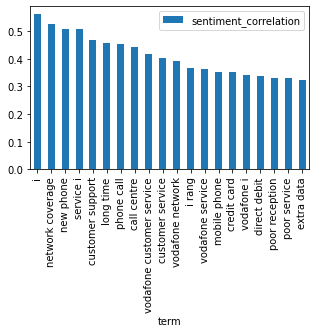

In [178]:
nounphrases_correlations[nounphrases_correlations['count']>20].sort_values(by='sentiment_correlation',ascending=False).head(20).plot(kind='bar',figsize=(5,3), x='term', y='sentiment_correlation')


<AxesSubplot:xlabel='term'>

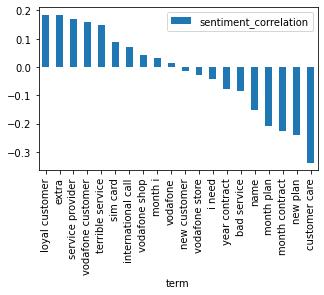

In [179]:
nounphrases_correlations[nounphrases_correlations['count']>20].sort_values(by='sentiment_correlation',ascending=False).tail(20).plot(kind='bar',figsize=(5,3), x='term', y='sentiment_correlation')


<AxesSubplot:xlabel='term'>

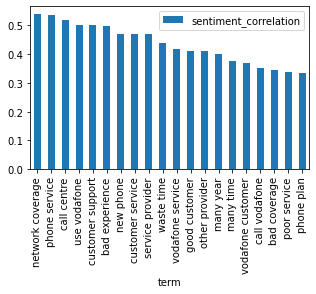

In [181]:
bi_gram_correlations[bi_gram_correlations['count']>30].sort_values(by='sentiment_correlation',ascending=False).head(20).plot(kind='bar',figsize=(5,3), x='term', y='sentiment_correlation')

<AxesSubplot:xlabel='term'>

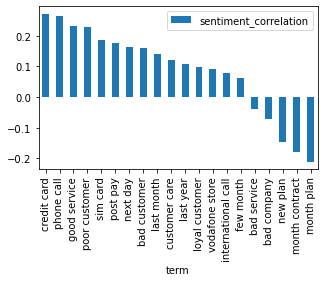

In [182]:
bi_gram_correlations[bi_gram_correlations['count']>30].sort_values(by='sentiment_correlation',ascending=False).tail(20).plot(kind='bar',figsize=(5,3), x='term', y='sentiment_correlation')


<AxesSubplot:xlabel='term'>

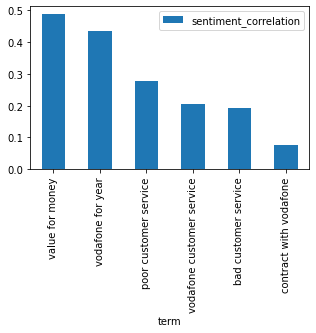

In [183]:
tri_gram_correlations[tri_gram_correlations['count']>30].sort_values(by='sentiment_correlation',ascending=False).head(20).plot(kind='bar',figsize=(5,3), x='term', y='sentiment_correlation')

<AxesSubplot:xlabel='term'>

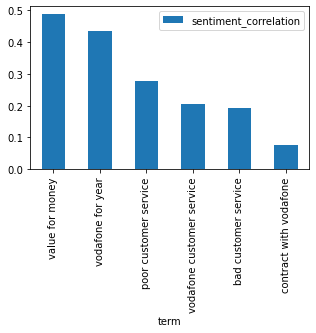

In [184]:
tri_gram_correlations[tri_gram_correlations['count']>30].sort_values(by='sentiment_correlation',ascending=False).tail(20).plot(kind='bar',figsize=(5,3), x='term', y='sentiment_correlation')
